# BIRD SPECIES CLASSIFICATION with DEEP LEARNING

## 1. Become one with the data

In [2]:
import os 
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pathlib, os, random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential


train = "data/train/"
test = "data/test/"
val = "data/valid/"


In [3]:
data_dir = Path("data/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # creating a list of class names from subdirectory 
print(class_names)

['ABBOTTS BABBLER' 'ABBOTTS BOOBY' 'ABYSSINIAN GROUND HORNBILL'
 'AFRICAN CROWNED CRANE' 'AFRICAN EMERALD CUCKOO' 'AFRICAN FIREFINCH'
 'AFRICAN OYSTER CATCHER' 'AFRICAN PIED HORNBILL' 'AFRICAN PYGMY GOOSE'
 'ALBATROSS' 'ALBERTS TOWHEE' 'ALEXANDRINE PARAKEET' 'ALPINE CHOUGH'
 'ALTAMIRA YELLOWTHROAT' 'AMERICAN AVOCET' 'AMERICAN BITTERN'
 'AMERICAN COOT' 'AMERICAN DIPPER' 'AMERICAN FLAMINGO'
 'AMERICAN GOLDFINCH' 'AMERICAN KESTREL' 'AMERICAN PIPIT'
 'AMERICAN REDSTART' 'AMERICAN ROBIN' 'AMERICAN WIGEON'
 'AMETHYST WOODSTAR' 'ANDEAN GOOSE' 'ANDEAN LAPWING' 'ANDEAN SISKIN'
 'ANHINGA' 'ANIANIAU' 'ANNAS HUMMINGBIRD' 'ANTBIRD' 'ANTILLEAN EUPHONIA'
 'APAPANE' 'APOSTLEBIRD' 'ARARIPE MANAKIN' 'ASHY STORM PETREL'
 'ASHY THRUSHBIRD' 'ASIAN CRESTED IBIS' 'ASIAN DOLLARD BIRD'
 'ASIAN GREEN BEE EATER' 'ASIAN OPENBILL STORK' 'AUCKLAND SHAQ'
 'AUSTRAL CANASTERO' 'AUSTRALASIAN FIGBIRD' 'AVADAVAT' 'AZARAS SPINETAIL'
 'AZURE BREASTED PITTA' 'AZURE JAY' 'AZURE TANAGER' 'AZURE TIT'
 'BAIKAL TEAL' 'BALD EAGLE

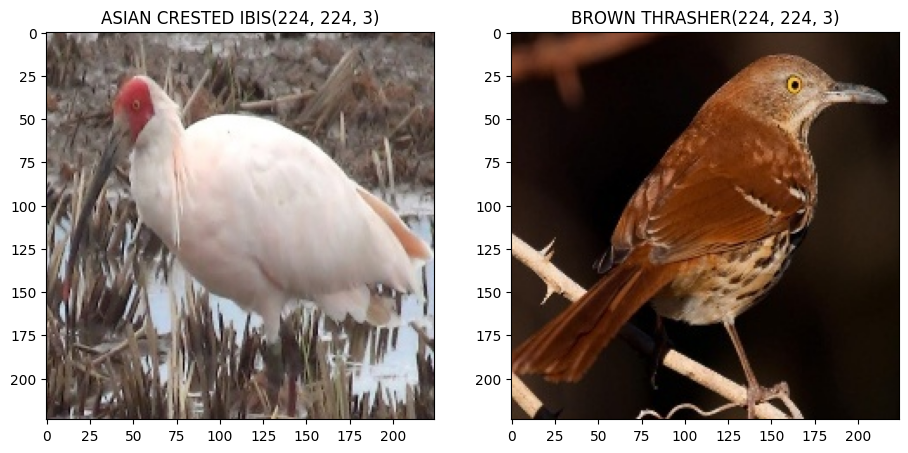

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def plot_random_bird_images(directory1, directory2):
    # Get the directory names
    dirname1 = os.path.basename(directory1)
    dirname2 = os.path.basename(directory2)
    
    # Get the list of image files in the directories
    image_files1 = [file for file in os.listdir(directory1) if os.path.isfile(os.path.join(directory1, file))]
    image_files2 = [file for file in os.listdir(directory2) if os.path.isfile(os.path.join(directory2, file))]
    
    # Select a random image file from each directory
    random_image1 = random.choice(image_files1)
    random_image2 = random.choice(image_files2)
    
    # Plot the selected images
    fig, ax = plt.subplots(1, 2, figsize=(11, 8))
    
    img1 = mpimg.imread(os.path.join(directory1, random_image1))
    ax[0].imshow(img1)
    ax[0].set_title(dirname1+ str(img1.shape))  # Display the directory name as the title
    ax[0].grid(False)
    
    img2 = mpimg.imread(os.path.join(directory2, random_image2))
    ax[1].imshow(img2)
    ax[1].set_title(dirname2 + str(img2.shape))  # Display the directory name as the title
    ax[1].grid(False)
    
    plt.show()

# Example usage:
plot_random_bird_images("data/train/ASIAN CRESTED IBIS", "data/train/BROWN THRASHER")



Data Preprocessing

In [5]:


def create_data_generator(directory):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    return train_datagen.flow_from_directory(
        directory=directory,
        batch_size=32,
        target_size=(300, 300),
        class_mode="categorical"
    )

train_data = create_data_generator(train)
test_data = create_data_generator(test)
val_data = create_data_generator(val)



Found 18748 images belonging to 118 classes.
Found 590 images belonging to 118 classes.
Found 590 images belonging to 118 classes.


## 3.Creating and fitting the Model

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Base model
base_model = tf.keras.applications.InceptionV3(input_shape=(300, 300, 3), include_top=False)
base_model.trainable = False

# Build model function
def build_sequential_model(base_model):
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(118, activation="softmax", name="output-layer")
    ])
    return model

# Compile model function
def compile_model(model):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train model function with early stopping
def train_model(model, train_data, val_data, epochs=25):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
    history = model.fit(train_data,
                        epochs=epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=int(0.25 * len(val_data)),
                        callbacks=[early_stopping])
    return history

# Evaluate model function
def evaluate_model(model, test_data):
    test_loss, test_accuracy = model.evaluate(test_data)
    predictions = model.predict(test_data)
    predicted_labels = tf.argmax(predictions, axis=1)
    true_labels = test_data.labels
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    return test_loss, test_accuracy, report

# Plot training history
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


model = build_sequential_model(base_model)
model = compile_model(model)
history = train_model(model, train_data, val_data)

test_loss, test_accuracy, report = evaluate_model(model, test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print("Classification Report:")
print(report)

plot_history(history)


Epoch 1/25


SystemError: \objects\listobject.c:337: bad argument to internal function

In [20]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output-layer (Dense)            │ (None, 118)            │       241,782 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,528,132 (85.94 MB)

 Trainable params: 241,782 (944.46 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 483,566 (1.84 MB)

In [21]:
model.evaluate(test_data)

19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9217 - loss: 0.2974


[0.31309381127357483, 0.9186440706253052]

In [25]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

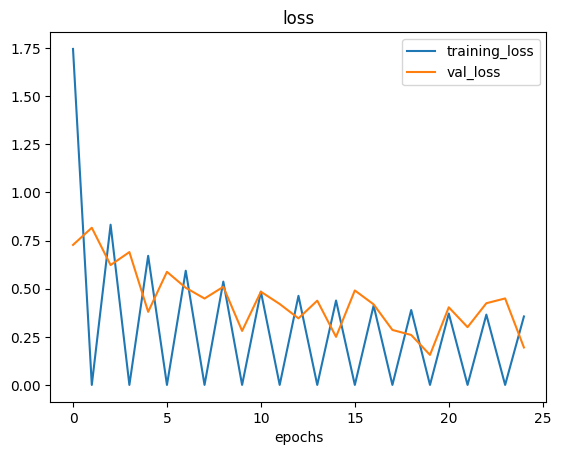

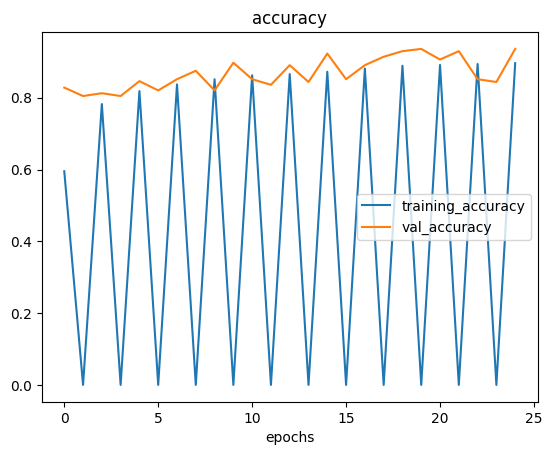

In [26]:
plot_loss_curves(history)

In [18]:
import os

# Specify the path to save the model
file_path = os.path.join('models', 'V2-imageclassifier.keras')

# Delete the existing model directory if it exists
if os.path.exists(file_path):
    try:
        os.rmdir(file_path)
        print(f"Existing model directory '{file_path}' deleted successfully.")
    except Exception as e:
        print(f"Error deleting existing model directory '{file_path}': {e}")

# Save the model in the native Keras format
try:
    model.save(file_path)
    print(f"Model saved to '{file_path}' successfully.")
except Exception as e:
    print(f"Error saving model to '{file_path}': {e}")


Model saved to 'models\V2-imageclassifier.keras' successfully.


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
from tensorflow.keras.preprocessing import image

def load_and_process_image(image_path):
    try:
        # Read the image
        img = cv2.imread(image_path)
        # Resize the image to the target size
        img = cv2.resize(img,(300, 300))
        # Convert the image to array format and rescale its pixel values
        img = img / 255.0
        # Expand dimensions to create a batch of size 1
        img = np.expand_dims(img, axis=0)
        return img
    except Exception as e:
        print("Error loading and processing image:", e)
        return None

def predict_and_plot_single_image(model, image_path, class_names):
    # Load and preprocess the image
    img = load_and_process_image(image_path)
    # Predict the class probabilities
    predictions = model.predict(img)
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])
    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]
    
    # Read the image in RGB color space
    img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.imshow(img_rgb)
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.axis("off")
    plt.show()

# Example usag
    
loaded_model = tf.keras.models.load_model('models/V2-imageclassifier.keras')

image_path = "data/buffledacnis2.jpg"
predict_and_plot_single_image(loaded_model, image_path, class_names)


ValueError: Layer 'output-layer' expected 1 input(s). Received 2 instead.